# WESM Forecasting

In [ ]:
!pip install tkan -q

## Train on 2023 Data

In [ ]:
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tkan import TKAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("drive/MyDrive/rtd_data/rtd_reduced.csv")
data.head()

,run_time,mkt_reqt
0,2022-01-01 00:00:00+00:00,8209.66
1,2022-01-01 00:05:00+00:00,8241.92
2,2022-01-01 00:10:00+00:00,8171.55
3,2022-01-01 00:15:00+00:00,8124.73
4,2022-01-01 00:20:00+00:00,8129.98


In [ ]:
data["run_time"] = pd.to_datetime(data["run_time"])
data.sort_values("run_time", inplace=True)
data.dropna(inplace=True)
data

,run_time,mkt_reqt
0,2022-01-01 00:00:00+00:00,8209.66
1,2022-01-01 00:05:00+00:00,8241.92
2,2022-01-01 00:10:00+00:00,8171.55
3,2022-01-01 00:15:00+00:00,8124.73
4,2022-01-01 00:20:00+00:00,8129.98
...,...,...
331872,2025-02-28 23:30:00+00:00,12018.14
331873,2025-02-28 23:35:00+00:00,11977.23
331874,2025-02-28 23:40:00+00:00,11937.51
331875,2025-02-28 23:45:00+00:00,11884.45


In [ ]:
data["hour"] = data["run_time"].dt.hour
data["day"] = data["run_time"].dt.day
data["dayofweek"] = data["run_time"].dt.dayofweek
data["month"] = data["run_time"].dt.month

In [ ]:
data

,run_time,mkt_reqt,hour,day,dayofweek,month
0,2022-01-01 00:00:00+00:00,8209.66,0,1,5,1
1,2022-01-01 00:05:00+00:00,8241.92,0,1,5,1
2,2022-01-01 00:10:00+00:00,8171.55,0,1,5,1
3,2022-01-01 00:15:00+00:00,8124.73,0,1,5,1
4,2022-01-01 00:20:00+00:00,8129.98,0,1,5,1
...,...,...,...,...,...,...
331872,2025-02-28 23:30:00+00:00,12018.14,23,28,4,2
331873,2025-02-28 23:35:00+00:00,11977.23,23,28,4,2
331874,2025-02-28 23:40:00+00:00,11937.51,23,28,4,2
331875,2025-02-28 23:45:00+00:00,11884.45,23,28,4,2


In [66]:
filter = data[(data["run_time"]>="2022-12-31") & (data["run_time"]<"2024-01-01")]

feature_columns = ["mkt_reqt", "day", "dayofweek", "month", "hour"]
data_series = filter["mkt_reqt"].values.reshape(-1, 1)

In [67]:
def generate_data(data,window_size=288, future_steps=288):
    X_new, y_new = [], []
    for i in range(len(data) - window_size - future_steps + 1):
        X_new.append(data[i : i + window_size])
        y_new.append(data[i + window_size:i + window_size + future_steps].flatten())

    X_new = np.array(X_new)
    y_new = np.array(y_new)

    return X_new, y_new

In [68]:
scaler = MinMaxScaler()
data_series_scaled = scaler.fit_transform(data_series)
X, y = generate_data(data_series_scaled)

window_size = 288  # 1 day of past data
future_steps = 288
results = []

epochs = 1

In [ ]:
# TKAN
model_tkan = Sequential([
    TKAN(200, sub_kan_configs=[{"spline_order": 4, "grid_size": 12}, {"spline_order": 3, "grid_size": 10}, {"spline_order": 5, "grid_size": 8}],
        return_sequences=False, use_bias=True),
    Dense(units=future_steps, activation="linear")
])

model_tkan.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
history_tkan = model_tkan.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2)

# LSTM
model_lstm = Sequential([
    LSTM(200, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(units=future_steps, activation="linear")
])
model_lstm.compile(optimizer="adam", loss="mse")

history_lstm = model_lstm.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2)

2605/2605 ━━━━━━━━━━━━━━━━━━━━ 384s 138ms/step - loss: 0.0087 - val_loss: 0.0064


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2605/2605 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0065 - val_loss: 0.0054


In [ ]:
with open("drive/MyDrive/rtd_data/history_tkan_1_2023.pkl", "wb") as f:
    pickle.dump(history_tkan, f)

with open("drive/MyDrive/rtd_data/history_lstm_1_2023.pkl", "wb") as f:
    pickle.dump(history_lstm, f)

In [ ]:
model_tkan.save("drive/MyDrive/rtd_data/tkan_model_1_2023.keras")
model_lstm.save("drive/MyDrive/rtd_data/lstm_model_1_2023.keras")

In [69]:
y_pred_tkan = model_tkan.predict(X)
y_pred_lstm = model_lstm.predict(X)

3256/3256 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step


In [70]:
y_pred_tkan_inverse = scaler.inverse_transform(y_pred_tkan)
y_pred_lstm_inverse = scaler.inverse_transform(y_pred_lstm)
y_inverse = scaler.inverse_transform(y)  # Actual values

time_index = filter["run_time"].iloc[window_size:window_size + len(y_inverse)].values

In [71]:
df_results = pd.DataFrame({
    "time_index": time_index,  # Timestamps
    "actual_demand": y_inverse[:, 0],  # First actual future step
    "tkan_predicted_demand": y_pred_tkan_inverse[:, 0],
    "lstm_predicted_demand": y_pred_lstm_inverse[:, 0]
})

df_results

,time_index,actual_demand,tkan_predicted_demand,lstm_predicted_demand
0,2023-01-01 00:00:00,9549.94,9670.054688,9329.590820
1,2023-01-01 00:05:00,9533.03,9642.983398,9302.696289
2,2023-01-01 00:10:00,9523.40,9618.071289,9276.136719
3,2023-01-01 00:15:00,9408.86,9590.723633,9250.994141
4,2023-01-01 00:20:00,9411.26,9554.106445,9208.004883
...,...,...,...,...
104169,2023-12-30 23:40:00,11017.56,11106.226562,10955.336914
104170,2023-12-30 23:45:00,10979.28,11055.825195,10904.167969
104171,2023-12-30 23:50:00,10936.32,11011.046875,10853.730469
104172,2023-12-30 23:55:00,10891.35,10965.305664,10802.970703


In [72]:
df_results.to_csv("drive/MyDrive/rtd_data/training_predictions_1.csv", index=False)

In [73]:
from sklearn.metrics import mean_absolute_percentage_error

mape_tkan = mean_absolute_percentage_error(df_results["actual_demand"], df_results["tkan_predicted_demand"])
mape_lstm = mean_absolute_percentage_error(df_results["actual_demand"], df_results["lstm_predicted_demand"])

print(mape_tkan, mape_lstm)

0.028815428410321173 0.029926805021052116


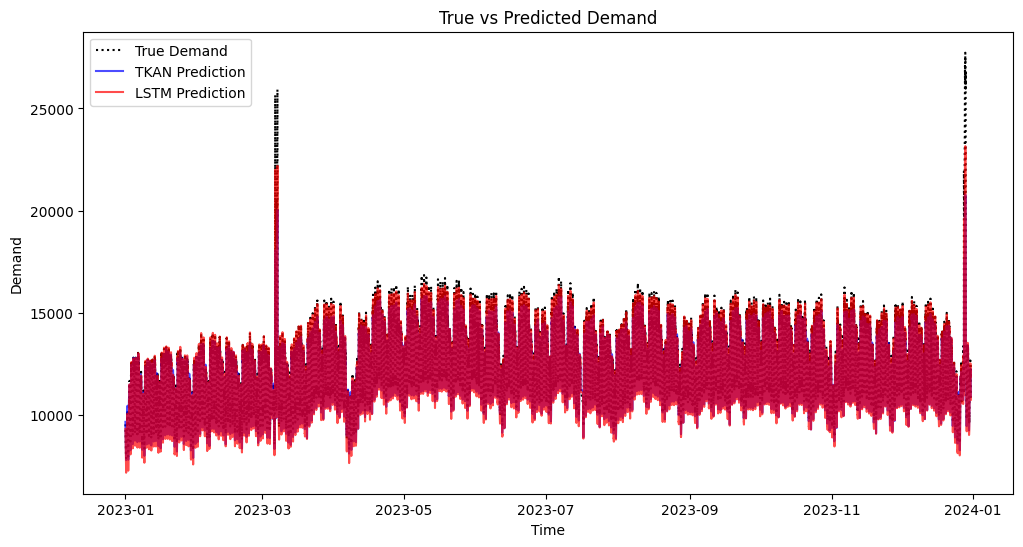

In [74]:
plt.figure(figsize=(12, 6))

# Plot original values
plt.plot(time_index, y_inverse[:, 0], label="True Demand", color="black", linestyle="dotted")

# Plot TKAN predictions
plt.plot(time_index, y_pred_tkan_inverse[:, 0], label="TKAN Prediction", color="blue", alpha=0.7)

# Plot LSTM predictions
plt.plot(time_index, y_pred_lstm_inverse[:, 0], label="LSTM Prediction", color="red", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("True vs Predicted Demand")
plt.legend()
plt.show()


### Predict on 2024 Data

In [ ]:
filter = data[(data["run_time"]>="2023-12-31") & (data["run_time"]<"2025-01-01")]

data_series = filter["mkt_reqt"].values.reshape(-1, 1)

data_series_scaled = scaler.transform(data_series)
X, y = generate_data(data_series_scaled)

window_size = 288  # 1 day of past data
future_steps = 288

In [ ]:
y_pred_tkan = model_tkan.predict(X)
y_pred_lstm = model_lstm.predict(X)

y_pred_tkan_inverse = scaler.inverse_transform(y_pred_tkan)
y_pred_lstm_inverse = scaler.inverse_transform(y_pred_lstm)
y_inverse = scaler.inverse_transform(y)  # Actual values

time_index = filter["run_time"].iloc[window_size:window_size + len(y_inverse)].values

3285/3285 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step


In [39]:
df_results = pd.DataFrame({
    "time_index": time_index,  # Timestamps
    "actual_demand": y_inverse[:, 0],  # First actual future step
    "tkan_predicted_demand": y_pred_tkan_inverse[:, 0],
    "lstm_predicted_demand": y_pred_lstm_inverse[:, 0]
})

df_results.to_csv("drive/MyDrive/rtd_data/predictions_2024_1.csv", index=False)
df_results

,time_index,actual_demand,tkan_predicted_demand,lstm_predicted_demand
0,2024-01-01 00:00:00,10764.44,10668.410156,10606.753906
1,2024-01-01 00:05:00,10773.44,10635.044922,10571.671875
2,2024-01-01 00:10:00,10751.24,10604.669922,10544.000000
3,2024-01-01 00:15:00,10526.44,10575.690430,10516.602539
4,2024-01-01 00:20:00,10481.28,10523.773438,10452.863281
...,...,...,...,...
105085,2024-12-30 23:40:00,10839.77,10963.079102,10710.731445
105086,2024-12-30 23:45:00,10800.76,10919.453125,10665.998047
105087,2024-12-30 23:50:00,10737.04,10876.254883,10621.358398
105088,2024-12-30 23:55:00,10627.13,10837.977539,10571.952148


In [40]:
mape_tkan = mean_absolute_percentage_error(df_results["actual_demand"], df_results["tkan_predicted_demand"])
mape_lstm = mean_absolute_percentage_error(df_results["actual_demand"], df_results["lstm_predicted_demand"])

print(mape_tkan, mape_lstm)

0.03179090572218447 0.03034877474520975


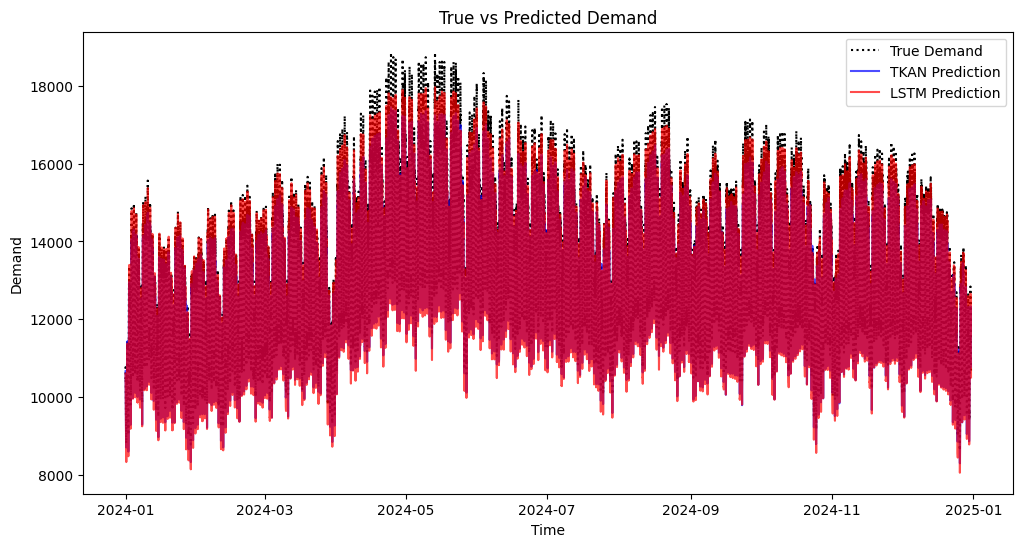

In [41]:
plt.figure(figsize=(12, 6))

# Plot original values
plt.plot(time_index, y_inverse[:, 0], label="True Demand", color="black", linestyle="dotted")

# Plot TKAN predictions
plt.plot(time_index, y_pred_tkan_inverse[:, 0], label="TKAN Prediction", color="blue", alpha=0.7)

# Plot LSTM predictions
plt.plot(time_index, y_pred_lstm_inverse[:, 0], label="LSTM Prediction", color="red", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("True vs Predicted Demand")
plt.legend()
plt.show()


### Predict on 2025 Data

In [48]:
filter = data[(data["run_time"]>="2024-12-31")]

data_series = filter["mkt_reqt"].values.reshape(-1, 1)

data_series_scaled = scaler.transform(data_series)
X, y = generate_data(data_series_scaled)

window_size = 288  # 1 day of past data
future_steps = 288

In [49]:
y_pred_tkan = model_tkan.predict(X)
y_pred_lstm = model_lstm.predict(X)

y_pred_tkan_inverse = scaler.inverse_transform(y_pred_tkan)
y_pred_lstm_inverse = scaler.inverse_transform(y_pred_lstm)
y_inverse = scaler.inverse_transform(y)  # Actual values

time_index = filter["run_time"].iloc[window_size:window_size + len(y_inverse)].values

522/522 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [50]:
df_results = pd.DataFrame({
    "time_index": time_index,  # Timestamps
    "actual_demand": y_inverse[:, 0],  # First actual future step
    "tkan_predicted_demand": y_pred_tkan_inverse[:, 0],
    "lstm_predicted_demand": y_pred_lstm_inverse[:, 0]
})

df_results.to_csv("drive/MyDrive/rtd_data/predictions_2025_1.csv", index=False)
df_results

,time_index,actual_demand,tkan_predicted_demand,lstm_predicted_demand
0,2025-01-01 00:00:00,10779.81,10608.603516,10495.038086
1,2025-01-01 00:05:00,10718.40,10579.554688,10471.797852
2,2025-01-01 00:10:00,10706.07,10545.166992,10440.854492
3,2025-01-01 00:15:00,10673.99,10512.208984,10411.990234
4,2025-01-01 00:20:00,10587.48,10478.429688,10381.967773
...,...,...,...,...
16699,2025-02-27 23:35:00,11727.57,11646.554688,11350.429688
16700,2025-02-27 23:40:00,11678.41,11591.558594,11304.138672
16701,2025-02-27 23:45:00,11627.20,11537.095703,11257.458984
16702,2025-02-27 23:50:00,11621.68,11482.187500,11211.692383


In [51]:
mape_tkan = mean_absolute_percentage_error(df_results["actual_demand"], df_results["tkan_predicted_demand"])
mape_lstm = mean_absolute_percentage_error(df_results["actual_demand"], df_results["lstm_predicted_demand"])

print(mape_tkan, mape_lstm)

0.027903078388282227 0.027098496132389623


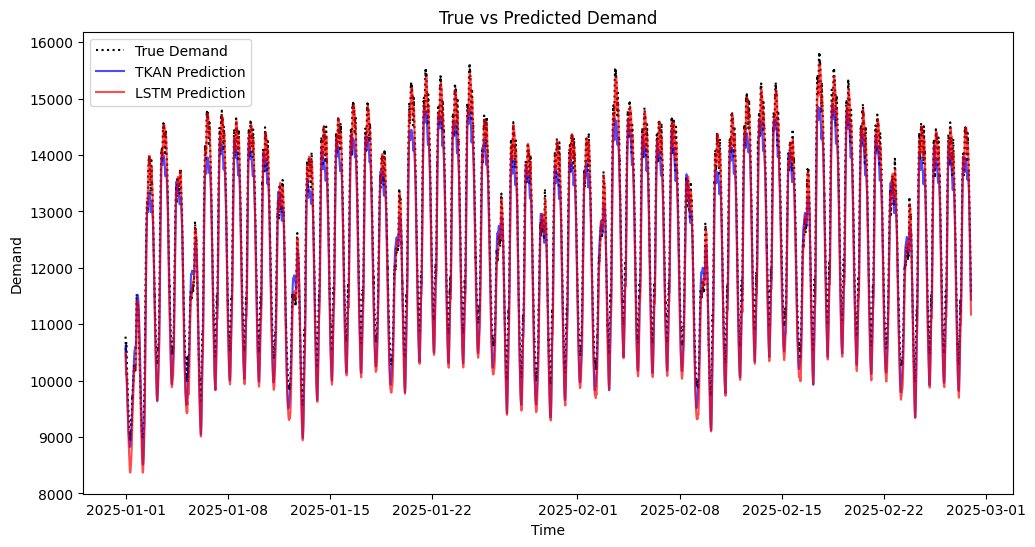

In [52]:
plt.figure(figsize=(12, 6))

# Plot original values
plt.plot(time_index, y_inverse[:, 0], label="True Demand", color="black", linestyle="dotted")

# Plot TKAN predictions
plt.plot(time_index, y_pred_tkan_inverse[:, 0], label="TKAN Prediction", color="blue", alpha=0.7)

# Plot LSTM predictions
plt.plot(time_index, y_pred_lstm_inverse[:, 0], label="LSTM Prediction", color="red", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("True vs Predicted Demand")
plt.legend()
plt.show()